In [75]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from get_dataframes import get_global_df

In [76]:
results_path = "../../../experiments/final_experiments"

global_df = get_global_df(results_path=results_path)
pd.set_option('display.max_colwidth', None)

In [77]:
# sisu_df = pd.read_csv("~/Downloads/sisu_ufpr_curitiba.csv", 
#                       encoding="latin1",
#                       sep=None,       # Try to auto-detect the separator
#                       engine='python', # Use the python engine which is more flexible
#                       quoting=3)      # QUOTE_NONE: don't use quotes
# sisu_df = pd.read_csv("../../../datasets/sisu_ufpr_curitiba_politecnico.csv")

In [78]:
# Filter the SISU dataframe to only include rows where SIGLA_IES is UFPR
# sisu_ufpr_df = sisu_df[sisu_df['"SIGLA_IES"'] == '"UFPR"']
# sisu_ufpr_curitiba_df = sisu_ufpr_df[sisu_ufpr_df['"NO_MUNUCIPIO_CAMPUS"'] == '"Curitiba"']

# sisu_df
# sisu_df.columns.tolist()


In [79]:
data = []
datasets_path = "../../../datasets/final"
if os.path.exists(datasets_path):
    for filename in os.listdir(datasets_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(datasets_path, filename)
            df = pd.read_csv(file_path)
            num_rows = len(df)
            num_columns = len(df.columns)
            data.append([filename.split('.')[0], num_rows, num_columns])

# Create a DataFrame with dataset information
datasets_info = pd.DataFrame(data, columns=['dataset', 'num_rows', 'num_columns'])
datasets_info

,dataset,num_rows,num_columns
0,ncvoter,1000,19
1,hate_crimes,3255,14
2,wifi_hotspot_location,3319,29
3,sisu_ufpr_curitiba_politecnico,2339,29
4,adult,1799,15
5,leading_causes_of_death,1094,7
6,iris,150,5


In [80]:
# Create a function to count the number of FDs for each algorithm-dataset combination
def count_fds_by_algorithm_dataset(df):
    # Group by algorithm and dataset, count the number of FDs
    counts = df.groupby(['algorithm', 'dataset']).size().reset_index(name='count')
    
    # Pivot the table to have datasets as columns and algorithms as rows
    pivot_df = counts.pivot(index='algorithm', columns='dataset', values='count')
    
    # Fill NaN values with 0
    pivot_df = pivot_df.fillna(0).astype(int)
    
    return pivot_df

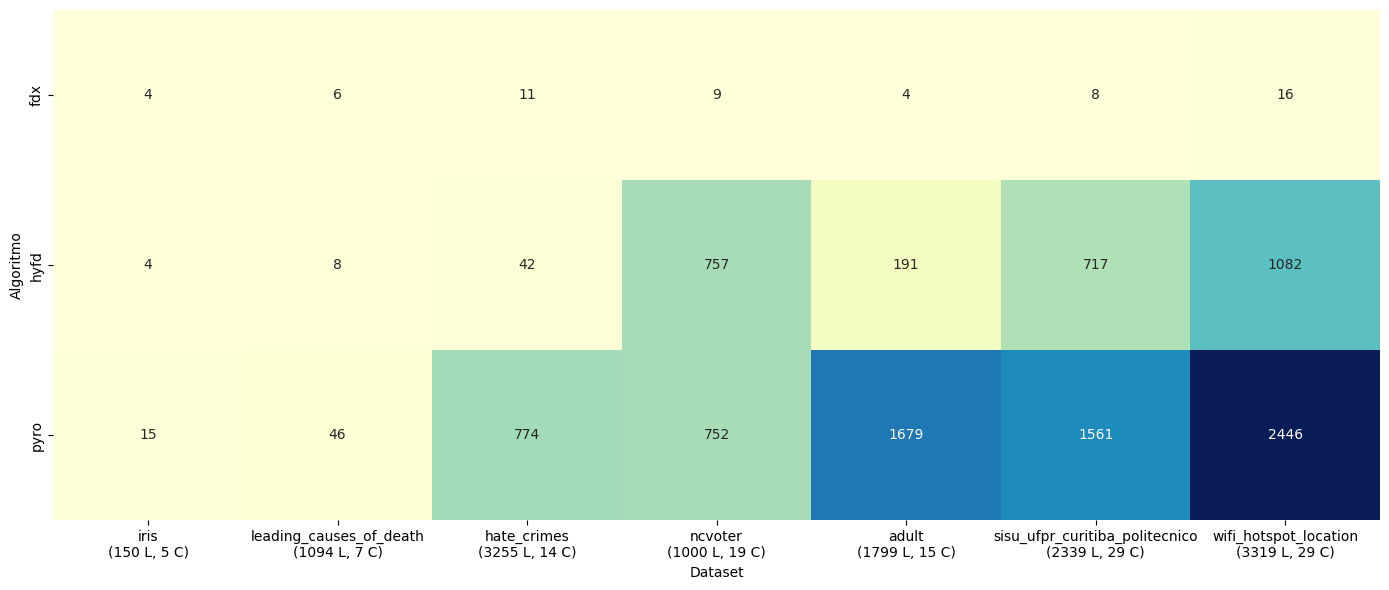

In [81]:
# Create a matrix showing the number of FDs for each algorithm-dataset combination
fd_count_matrix = count_fds_by_algorithm_dataset(global_df)

# Calculate total FDs per dataset for sorting
total_fds_per_dataset = fd_count_matrix.sum().sort_values()
sorted_datasets = total_fds_per_dataset.index.tolist()

# Reindex the matrix to have datasets in ascending order by FD count
fd_count_matrix = fd_count_matrix[sorted_datasets]

# Display the matrix
fd_count_matrix

# Create custom x-tick labels with dataset info
custom_labels = []
for dataset in sorted_datasets:
    # Find the dataset info
    dataset_info = datasets_info[datasets_info['dataset'] == dataset]
    if not dataset_info.empty:
        rows = dataset_info['num_rows'].values[0]
        cols = dataset_info['num_columns'].values[0]
        custom_labels.append(f"{dataset}\n({rows} L, {cols} C)")
    else:
        custom_labels.append(dataset)

# Optional: Create a heatmap visualization
plt.figure(figsize=(14, 6))  # Made figure wider to accommodate larger labels
sns.heatmap(fd_count_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.ylabel('Algoritmo')
plt.xlabel('Dataset')
plt.xticks(ticks=np.arange(len(sorted_datasets)) + 0.5, labels=custom_labels, rotation=0)
plt.tight_layout()
plt.show()

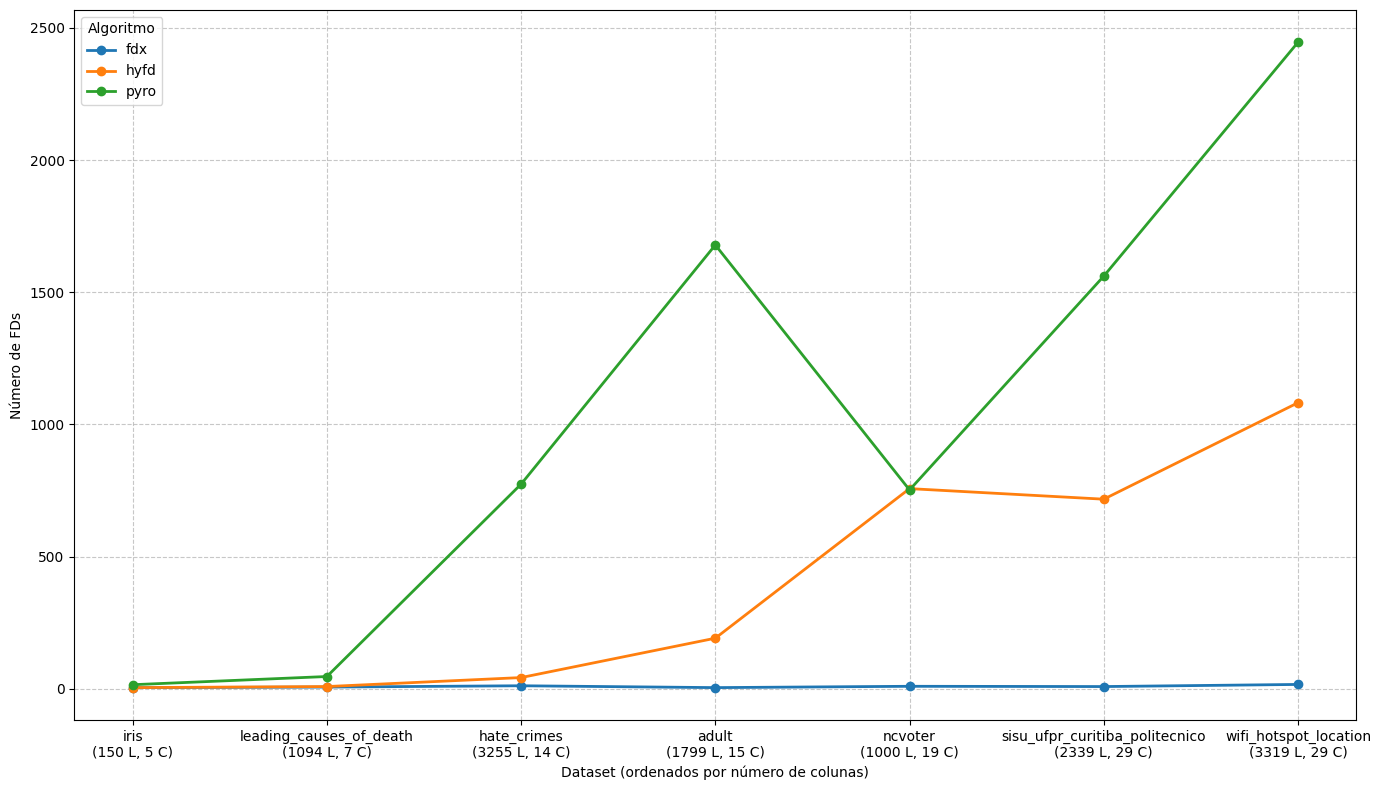

In [82]:
# Sort datasets by number of columns
datasets_sorted_by_columns = datasets_info.sort_values('num_columns')['dataset'].tolist()

# Create a new DataFrame for plotting where datasets are in order of number of columns
plot_df = pd.DataFrame()
for algorithm in fd_count_matrix.index:
    for dataset in datasets_sorted_by_columns:
        if dataset in fd_count_matrix.columns:
            new_row = pd.DataFrame({
                'algorithm': [algorithm],
                'dataset': [dataset],
                'fd_count': [fd_count_matrix.loc[algorithm, dataset]],
                'num_columns': [datasets_info[datasets_info['dataset'] == dataset]['num_columns'].values[0]],
                'num_rows': [datasets_info[datasets_info['dataset'] == dataset]['num_rows'].values[0]]
            })
            plot_df = pd.concat([plot_df, new_row], ignore_index=True)

# Create line plot
plt.figure(figsize=(14, 8))

# Create custom x-tick labels with dataset info
custom_labels = []
for dataset in datasets_sorted_by_columns:
    # Find the dataset info
    dataset_info = datasets_info[datasets_info['dataset'] == dataset]
    if not dataset_info.empty:
        rows = dataset_info['num_rows'].values[0]
        cols = dataset_info['num_columns'].values[0]
        custom_labels.append(f"{dataset}\n({rows} L, {cols} C)")
    else:
        custom_labels.append(dataset)

# Get unique algorithms for the legend
algorithms = plot_df['algorithm'].unique()

# Plot each algorithm as a separate line
for algorithm in algorithms:
    algo_data = plot_df[plot_df['algorithm'] == algorithm]
    # Sort by number of columns to ensure correct order, then by number of rows
    algo_data = algo_data.sort_values(['num_columns', 'num_rows'])
    plt.plot(algo_data['dataset'], algo_data['fd_count'], marker='o', linewidth=2, label=algorithm)

plt.xlabel('Dataset (ordenados por número de colunas)')
plt.ylabel('Número de FDs')
plt.legend(title='Algoritmo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(datasets_sorted_by_columns, custom_labels, rotation=0)
plt.tight_layout()
plt.show()